# Feature Sieve Regression
## Dataset: Facial Beauty SCUT - FBP5500

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
import os

from torchsummary import summary
from tqdm import tqdm
import matplotlib.patches as mpatches
import seaborn as sns

# importing functions for the models
from scripts.models import *
from scripts.train import *

In [2]:
# initializing the seeds
SEED = 3407
# setting random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
torch.cuda.set_device(1)
print(device)

cuda


## Data

In [3]:
DATA_PATH = "./FacialBeautyData/scut_fbp5500-cmprsd.npz"
data = np.load(DATA_PATH)
inputs, targets = data['X'], data['y']
inputs = inputs.reshape((-1, inputs.shape[-1], inputs.shape[1],inputs.shape[2]))
print(f"Data shape: {inputs.shape}")

Data shape: (5500, 3, 350, 350)


In [4]:
TRAIN_PTS, VALID_PTS, TEST_PTS = int(inputs.shape[0] * 0.6), int(inputs.shape[0] * 0.2), int(inputs.shape[0] * 0.2)

train_data, train_targets = inputs[:TRAIN_PTS].astype(np.float32), targets[:TRAIN_PTS].astype(np.float32)
valid_data, valid_targets = inputs[TRAIN_PTS: TRAIN_PTS + VALID_PTS].astype(np.float32), targets[TRAIN_PTS: TRAIN_PTS + VALID_PTS].astype(np.float32)
test_data, test_targets = inputs[TRAIN_PTS + VALID_PTS: ].astype(np.float32), targets[TRAIN_PTS + VALID_PTS: ].astype(np.float32)

print(f"# of Training points: {train_data.shape[0]}")
print(f"# of Valid points: {valid_data.shape[0]}")
print(f"# of Test points: {test_data.shape[0]}")

# of Training points: 3300
# of Valid points: 1100
# of Test points: 1100


In [5]:
# getting the ethinicity and gender
with open("./FacialBeautyData/labels.txt") as f:
    lines = f.readlines()
    lines = [i.rstrip().split() for i in lines]
    # Gender: M --> 1 F--> 0
    # Ethinicity: A --> 1 C --> 0
    gender = [1 if i[0][1] == "M" else 0 for i in lines ]
    ethinicity = [1 if i[0][0]== "A" else 0  for i in lines]
    labels = [i[0][:-4] for i in lines]

gender = np.array(gender)
ethinicity = np.array(ethinicity)
labels = np.array(labels)

# correlation Calculation
data_df = pd.DataFrame(np.array([labels, gender, ethinicity, targets]).T, columns = ['Labels', "Gender", 'Ethinicity', 'Targets'])
data_df = data_df.set_index("Labels").astype(float)
data_df = data_df.reset_index()
data_df.head()

,Labels,Gender,Ethinicity,Targets
0,CF437,0.0,0.0,2.883333
1,AM1384,1.0,1.0,2.466667
2,AM1234,1.0,1.0,2.150000
3,AM1774,1.0,1.0,3.750000
4,CF215,0.0,0.0,3.033333


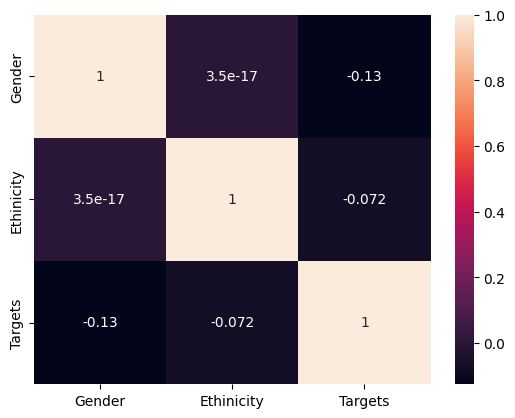

In [6]:
# correaltion bprint(y)etween variables
corr = data_df.corr(numeric_only = True)
sns.heatmap(corr, annot = True)
plt.show()

In [7]:
# counts of different groups
groups = {"Training": data_df[:TRAIN_PTS], 
         "Validation": data_df[TRAIN_PTS: TRAIN_PTS + VALID_PTS], 
         "Test": data_df[TRAIN_PTS + VALID_PTS: ]}

counts = {"male > 2.5": [], "male <= 2.5": [], "female > 2.5":[], "female <= 2.5": [], "Total": []}

for group, df in groups.items():
    male_df = df[df['Gender'] == 1]
    female_df = df[df['Gender'] == 0]

    male_b_df = df[df['Targets'] > 2.5]
    male_u_df = df[df['Targets'] <= 2.5]

    female_b_df = df[df['Targets']> 2.5]
    female_u_df = df[df['Targets'] <= 2.5]

    counts['male > 2.5'].append(male_b_df.shape[0])
    counts['male <= 2.5'].append(male_u_df.shape[0])
    counts['female > 2.5'].append(female_b_df.shape[0])
    counts['female <= 2.5'].append(female_u_df.shape[0])
    counts['Total'].append(df.shape[0])

counts_df = pd.DataFrame(counts, index = groups.keys())
counts_df.T

,Training,Validation,Test
male > 2.5,2445,832,824
male <= 2.5,855,268,276
female > 2.5,2445,832,824
female <= 2.5,855,268,276
Total,3300,1100,1100


## Dataloaders and Dataset

In [8]:
BATCH_SIZE = 64

class FBPDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __getitem__(self, idx):
        x, y = self.inputs[idx], self.targets[idx]
        return x,y
    def __len__(self):
        return self.inputs.shape[0]

train_dataset = FBPDataset(train_data, train_targets)
valid_dataset = FBPDataset(valid_data, valid_targets)
test_dataset =  FBPDataset(test_data, test_targets)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## Groups
### Test groups

In [9]:
test_df = data_df[TRAIN_PTS + VALID_PTS: ]
male_df = test_df[test_df['Gender'] == 1]
female_df = test_df[test_df['Gender'] == 0]

male_b_df = male_df[male_df['Targets']> 2.5]
male_u_df = male_df[male_df['Targets']<= 2.5]

female_b_df = female_df[female_df['Targets'] > 2.5]
female_u_df = female_df[female_df['Targets'] <= 2.5]

male_b_df.head()

,Labels,Gender,Ethinicity,Targets
4400,AM1421,1.0,1.0,2.850000
4403,CM385,1.0,0.0,2.866667
4404,CM4,1.0,0.0,4.316667
4406,AM927,1.0,1.0,2.716667
4407,AM266,1.0,1.0,2.883333


In [10]:
male_b_data, male_b_targets = inputs[male_b_df.index.to_list()].astype(np.float32), targets[male_b_df.index.to_list()].astype(np.float32)
male_u_data, male_u_targets = inputs[male_u_df.index.to_list()].astype(np.float32), targets[male_u_df.index.to_list()].astype(np.float32)
female_u_data, female_u_targets = inputs[female_u_df.index.to_list()].astype(np.float32), targets[female_u_df.index.to_list()].astype(np.float32)
female_b_data, female_b_targets = inputs[female_b_df.index.to_list()].astype(np.float32), targets[female_b_df.index.to_list()].astype(np.float32)

print(f"# of datapoints of male above 2.5: {male_b_data.shape[0]}")
print(f"# of datapoints of male below 2.5: {male_u_data.shape[0]}")
print(f"# of datapoints of female above 2.5: {female_b_data.shape[0]}")
print(f"# of datapoins of female below 2.5: {female_u_data.shape[0]}")

# of datapoints of male above 2.5: 370
# of datapoints of male below 2.5: 151
# of datapoints of female above 2.5: 454
# of datapoins of female below 2.5: 125


In [11]:
male_b_dataset = FBPDataset(male_b_data, male_b_targets)
male_u_dataset = FBPDataset(male_u_data, male_u_targets)
female_b_dataset = FBPDataset(female_b_data, female_b_targets)
female_u_dataset = FBPDataset(female_u_data, female_u_targets)

male_b_dataloader = DataLoader(male_b_dataset, batch_size=BATCH_SIZE, shuffle  = True)
male_u_dataloader = DataLoader(male_u_dataset, batch_size=BATCH_SIZE, shuffle  = True)
female_b_dataloader = DataLoader(female_b_dataset, batch_size=BATCH_SIZE, shuffle  = True)
female_u_dataloader = DataLoader(female_u_dataset, batch_size=BATCH_SIZE, shuffle  = True)

group_test_dataloaders = {'m b': male_b_dataloader, "m u": male_u_dataloader, 'f b': female_b_dataloader, 'f u':female_u_dataloader}

### Validation groups

In [12]:
val_df = data_df[TRAIN_PTS: TRAIN_PTS + VALID_PTS]
male_val_df = val_df[val_df['Gender'] == 1]
female_val_df = val_df[val_df['Gender'] == 0]

male_b_val_df = male_val_df[male_val_df['Targets'] > 2.5]
male_u_val_df = male_val_df[male_val_df['Targets'] <= 2.5]

female_b_val_df = female_val_df[female_val_df['Targets'] > 2.5]
female_u_val_df = female_val_df[female_val_df['Targets']<= 2.5]

male_b_val_data, male_b_val_targets = inputs[male_b_val_df.index.to_list()].astype(np.float32), targets[male_b_val_df.index.to_list()].astype(np.float32)
male_u_val_data, male_u_val_targets = inputs[male_u_val_df.index.to_list()].astype(np.float32), targets[male_u_val_df.index.to_list()].astype(np.float32)
female_b_val_data, female_b_val_targets = inputs[female_b_val_df.index.to_list()].astype(np.float32), targets[female_b_val_df.index.to_list()].astype(np.float32)
female_u_val_data, female_u_val_targets = inputs[female_u_val_df.index.to_list()].astype(np.float32), targets[female_u_val_df.index.to_list()].astype(np.float32)

male_b_val_dataset = FBPDataset(male_b_val_data, male_b_val_targets)
male_u_val_dataset = FBPDataset(male_u_val_data, male_u_val_targets)
female_b_val_dataset = FBPDataset(female_b_val_data, female_b_val_targets)
female_u_val_dataset = FBPDataset(female_u_val_data, female_u_val_targets)

male_b_val_dataloader = DataLoader(male_b_val_dataset, batch_size = BATCH_SIZE, shuffle = True)
male_u_val_dataloader = DataLoader(male_u_val_dataset, batch_size = BATCH_SIZE, shuffle = True)
female_b_val_dataloader = DataLoader(female_b_val_dataset, batch_size = BATCH_SIZE, shuffle = True)
female_u_val_dataloader = DataLoader(female_u_val_dataset, batch_size = BATCH_SIZE, shuffle = True)

group_val_dataloaders = {"m b": male_b_val_dataloader, "m u": male_u_val_dataloader, "f b": female_b_val_dataloader, "f u": female_u_val_dataloader}

In [13]:
## eval functions
x, _ = next(iter(train_dataloader))
def group_eval_cnn(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_model(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
        
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ /count), groups

def group_eval_fs(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_FSModel(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
            
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ / count), groups

## 1) Resnet34 Results

In [14]:
# hyperparameter tuning
lrs = [1e-5, 5e-4, 1e-4, 5e-3,  1e-3, 1e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

test_losses = np.zeros((len(lrs), len(wds)))
grp_test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"[{i *len(wds) + j +1}/{len(lrs) * len(wds)}] Lr: {lrs[i]} WD:{wds[j]}")
        model = Resnet34(1).to(device)
        model, train_loss, val_loss = train(model, train_dataloader, valid_dataloader, epochs = 2, verbose = False, lr = lrs[i], weight_decay = wds[j])
        test_loss = eval_model(model, valid_dataloader)
        print(f"Test Loss: {test_loss}")
        group_tst_loss = group_eval_cnn(model, group_val_dataloaders)

        test_losses[i,j] = test_loss
        grp_test_losses[i,j] = group_tst_loss[0]

best_lr, best_wd = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_lr, best_grp_wd = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")
print(f"Group wise hyperparameters: \n Best LR: {lrs[best_grp_lr]} Best WD: {wds[best_grp_wd]}")

[1/36] Lr: 1e-05 WD:1e-05


  0%|                                                                                                                                                   | 0/2 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.62s/it]


Test Loss: 0.8436322808265686
Group test Loss: 0.691767118871212
[2/36] Lr: 1e-05 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.27s/it]


Test Loss: 0.6474447250366211
Group test Loss: 0.6247625350952148
[3/36] Lr: 1e-05 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.41s/it]


Test Loss: 0.8791970610618591
Group test Loss: 0.7517890371382236
[4/36] Lr: 1e-05 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.48s/it]


Test Loss: 0.920137345790863
Group test Loss: 0.7957795858383179
[5/36] Lr: 1e-05 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.31s/it]


Test Loss: 0.7644132971763611
Group test Loss: 0.6701707765460014
[6/36] Lr: 1e-05 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.43s/it]


Test Loss: 0.9328192472457886
Group test Loss: 0.8159603476524353
[7/36] Lr: 0.0005 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.46s/it]


Test Loss: 0.2738100290298462
Group test Loss: 0.5654378868639469
[8/36] Lr: 0.0005 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.51s/it]


Test Loss: 0.22720403969287872
Group test Loss: 0.5421780087053776
[9/36] Lr: 0.0005 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.45s/it]


Test Loss: 0.24271653592586517
Group test Loss: 0.5291123725473881
[10/36] Lr: 0.0005 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.39s/it]


Test Loss: 0.26421234011650085
Group test Loss: 0.5922700390219688
[11/36] Lr: 0.0005 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.43s/it]


Test Loss: 0.23155154287815094
Group test Loss: 0.52411288022995
[12/36] Lr: 0.0005 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.47s/it]


Test Loss: 0.29267656803131104
Group test Loss: 0.6309916377067566
[13/36] Lr: 0.0001 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.45s/it]


Test Loss: 0.25500908493995667
Group test Loss: 0.5377854034304619
[14/36] Lr: 0.0001 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.53s/it]


Test Loss: 0.27496227622032166
Group test Loss: 0.5824282988905907
[15/36] Lr: 0.0001 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.40s/it]


Test Loss: 0.23961465060710907
Group test Loss: 0.4859754256904125
[16/36] Lr: 0.0001 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.52s/it]


Test Loss: 0.28261423110961914
Group test Loss: 0.5772226750850677
[17/36] Lr: 0.0001 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.47s/it]


Test Loss: 0.2522010803222656
Group test Loss: 0.5674773715436459
[18/36] Lr: 0.0001 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.46s/it]


Test Loss: 0.2906278967857361
Group test Loss: 0.5940588191151619
[19/36] Lr: 0.005 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.50s/it]


Test Loss: 0.3620159924030304
Group test Loss: 0.48883936554193497
[20/36] Lr: 0.005 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.55s/it]


Test Loss: 0.4963035583496094
Group test Loss: 0.5668597146868706
[21/36] Lr: 0.005 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.54s/it]


Test Loss: 0.34960684180259705
Group test Loss: 0.5063846856355667
[22/36] Lr: 0.005 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.51s/it]


Test Loss: 0.42822733521461487
Group test Loss: 0.5337718352675438
[23/36] Lr: 0.005 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.47s/it]


Test Loss: 0.3634021282196045
Group test Loss: 0.5483144596219063
[24/36] Lr: 0.005 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.42s/it]


Test Loss: 0.5067429542541504
Group test Loss: 0.5649404749274254
[25/36] Lr: 0.001 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.43s/it]


Test Loss: 0.32761403918266296
Group test Loss: 0.44981978088617325
[26/36] Lr: 0.001 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.55s/it]


Test Loss: 0.2846839129924774
Group test Loss: 0.6119993627071381
[27/36] Lr: 0.001 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.56s/it]


Test Loss: 0.27814382314682007
Group test Loss: 0.4971648156642914
[28/36] Lr: 0.001 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.38s/it]


Test Loss: 0.2909175753593445
Group test Loss: 0.6267937123775482
[29/36] Lr: 0.001 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.42s/it]


Test Loss: 0.2988862097263336
Group test Loss: 0.5410658828914165
[30/36] Lr: 0.001 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.55s/it]


Test Loss: 0.3637544810771942
Group test Loss: 0.6877771802246571
[31/36] Lr: 0.01 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.48s/it]


Test Loss: 0.4061878025531769
Group test Loss: 0.5699936002492905
[32/36] Lr: 0.01 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.62s/it]


Test Loss: 0.5432663559913635
Group test Loss: 0.6215276420116425
[33/36] Lr: 0.01 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.52s/it]


Test Loss: 0.4797375500202179
Group test Loss: 0.6768789812922478
[34/36] Lr: 0.01 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.38s/it]


Test Loss: 0.5576066374778748
Group test Loss: 0.7587170973420143
[35/36] Lr: 0.01 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.30s/it]


Test Loss: 0.4781533479690552
Group test Loss: 0.5063565298914909
[36/36] Lr: 0.01 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.34s/it]


Test Loss: 0.5050321221351624
Group test Loss: 0.5695032775402069
Best LR: 0.0005 Best WD: 0.0005
Group wise hyperparameters: 
 Best LR: 0.001 Best WD: 1e-05


In [15]:
lrs = [1e-5, 5e-4, 1e-4, 5e-3,  1e-3, 1e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]
best_grp_lr, best_grp_wd = lrs.index(0.0005), wds.index(0.005)

model = Resnet34(1).to(device)
model, train_loss, val_loss = train(model, train_dataloader, valid_dataloader, epochs = 5, verbose = False, lr = lrs[best_grp_lr], weight_decay = wds[best_grp_wd])
test_loss_cnn = eval_model(model, test_dataloader)
print(f"Test Loss: {test_loss_cnn}")
group_tst_loss_cnn, groups_cnn = group_eval_cnn(model, group_test_dataloaders)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.49s/it]


Test Loss: 0.3197898268699646


/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Group test Loss: 0.7923559546470642


## 2) Margin forgetting loss

In [16]:
# hyperparameter tuning
# Hyperparameter Tuning
margins = [1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1e+1, 2e+1]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1} / {len(margins) * len(forget_lrs)* len(forget_iters)}] Margin {margins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_margin(x.shape, 1, aux_kernels = [128, 64], layers = [5, 4]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_mar(model, train_dataloader, valid_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, valid_dataloader)
            print(f"Test Loss: {test_loss}")
            grp_loss = group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = grp_loss[0]

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")
print(f"Group hyperparameters: \n Best margin: {margins[best_grp_margin]} Best Forget Lr: {forget_lrs[best_grp_forget_lr]} Best Forget Iter: {forget_iters[best_grp_forget_iter]}")

[1 / 84] Margin 1e-05 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.72s/it]


Test Loss: 0.24110038578510284
Group test Loss: 0.2817723713815212
[2 / 84] Margin 1e-05 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.74s/it]


Test Loss: 0.260263592004776
Group test Loss: 0.38365549966692924
[3 / 84] Margin 1e-05 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.71s/it]


Test Loss: 0.2162456512451172
Group test Loss: 0.2627793848514557
[4 / 84] Margin 1e-05 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.93s/it]


Test Loss: 0.3034248948097229
Group test Loss: 0.28662068769335747
[5 / 84] Margin 1e-05 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.81s/it]


Test Loss: 0.22644059360027313
Group test Loss: 0.27054208144545555
[6 / 84] Margin 1e-05 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.03s/it]


Test Loss: 0.2494080364704132
Group test Loss: 0.27553534135222435
[7 / 84] Margin 1e-05 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.82s/it]


Test Loss: 0.250243216753006
Group test Loss: 0.35622743144631386
[8 / 84] Margin 1e-05 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.80s/it]


Test Loss: 0.25301191210746765
Group test Loss: 0.3007226400077343
[9 / 84] Margin 1e-05 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.70s/it]


Test Loss: 0.24496157467365265
Group test Loss: 0.29209157824516296
[10 / 84] Margin 1e-05 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.92s/it]


Test Loss: 0.22424766421318054
Group test Loss: 0.24477041140198708
[11 / 84] Margin 1e-05 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.02s/it]


Test Loss: 0.25948336720466614
Group test Loss: 0.28141968324780464
[12 / 84] Margin 1e-05 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.90s/it]


Test Loss: 0.2409316748380661
Group test Loss: 0.2676711119711399
[13 / 84] Margin 0.0001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.89s/it]


Test Loss: 0.2404683381319046
Group test Loss: 0.27362413331866264
[14 / 84] Margin 0.0001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.69s/it]


Test Loss: 0.2431734949350357
Group test Loss: 0.30009937286376953
[15 / 84] Margin 0.0001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.91s/it]


Test Loss: 0.25961464643478394
Group test Loss: 0.3857823610305786
[16 / 84] Margin 0.0001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.05s/it]


Test Loss: 0.23167145252227783
Group test Loss: 0.30955833569169044
[17 / 84] Margin 0.0001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.67s/it]


Test Loss: 0.3152875602245331
Group test Loss: 0.27893446758389473
[18 / 84] Margin 0.0001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.03s/it]


Test Loss: 0.24209363758563995
Group test Loss: 0.2612317204475403
[19 / 84] Margin 0.0001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.74s/it]


Test Loss: 0.24000710248947144
Group test Loss: 0.29528673365712166
[20 / 84] Margin 0.0001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.06s/it]


Test Loss: 0.2852548658847809
Group test Loss: 0.4124104641377926
[21 / 84] Margin 0.0001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.04s/it]


Test Loss: 0.24419835209846497
Group test Loss: 0.2759539410471916
[22 / 84] Margin 0.0001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.90s/it]


Test Loss: 0.2229621261358261
Group test Loss: 0.2890636548399925
[23 / 84] Margin 0.0001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.59s/it]


Test Loss: 0.23178446292877197
Group test Loss: 0.2845158204436302
[24 / 84] Margin 0.0001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.74s/it]


Test Loss: 0.24259436130523682
Group test Loss: 0.3013019561767578
[25 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.91s/it]


Test Loss: 0.2707047164440155
Group test Loss: 0.372705303132534
[26 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.46s/it]


Test Loss: 0.292744517326355
Group test Loss: 0.26968666166067123
[27 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.66s/it]


Test Loss: 0.2959652841091156
Group test Loss: 0.26548390090465546
[28 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.36s/it]


Test Loss: 0.2716924846172333
Group test Loss: 0.31031595915555954
[29 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.82s/it]


Test Loss: 0.2165347784757614
Group test Loss: 0.2638704963028431
[30 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.89s/it]


Test Loss: 0.25602778792381287
Group test Loss: 0.35451508685946465
[31 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.79s/it]


Test Loss: 0.22970780730247498
Group test Loss: 0.29073482006788254
[32 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.19s/it]


Test Loss: 0.25287699699401855
Group test Loss: 0.3264843113720417
[33 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.02s/it]


Test Loss: 0.25100916624069214
Group test Loss: 0.3665335029363632
[34 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.97s/it]


Test Loss: 0.23871693015098572
Group test Loss: 0.29789501801133156
[35 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.21s/it]


Test Loss: 0.2347242534160614
Group test Loss: 0.31489842012524605
[36 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.27s/it]


Test Loss: 0.24630875885486603
Group test Loss: 0.3167261332273483
[37 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.74s/it]


Test Loss: 0.22930502891540527
Group test Loss: 0.30626748502254486
[38 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.47s/it]


Test Loss: 0.23342904448509216
Group test Loss: 0.2507529594004154
[39 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.11s/it]


Test Loss: 0.2630274295806885
Group test Loss: 0.3666783981025219
[40 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.86s/it]


Test Loss: 0.2506870925426483
Group test Loss: 0.29186099395155907
[41 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.02s/it]


Test Loss: 0.20815728604793549
Group test Loss: 0.2435746267437935
[42 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.82s/it]


Test Loss: 0.24095304310321808
Group test Loss: 0.32207050919532776
[43 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.05s/it]


Test Loss: 0.2616373300552368
Group test Loss: 0.3743518851697445
[44 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.67s/it]


Test Loss: 0.23663771152496338
Group test Loss: 0.3021060824394226
[45 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.08s/it]


Test Loss: 0.20990870893001556
Group test Loss: 0.25805390253663063
[46 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.21s/it]


Test Loss: 0.23847556114196777
Group test Loss: 0.2918405197560787
[47 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.60s/it]


Test Loss: 0.28114208579063416
Group test Loss: 0.4035557135939598
[48 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.16s/it]


Test Loss: 0.2293890416622162
Group test Loss: 0.2936273254454136
[49 / 84] Margin 0.1 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.58s/it]


Test Loss: 0.24780437350273132
Group test Loss: 0.2842899523675442
[50 / 84] Margin 0.1 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.92s/it]


Test Loss: 0.3257305920124054
Group test Loss: 0.3118399754166603
[51 / 84] Margin 0.1 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.13s/it]


Test Loss: 0.2190466672182083
Group test Loss: 0.2883130721747875
[52 / 84] Margin 0.1 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.87s/it]


Test Loss: 0.253099262714386
Group test Loss: 0.36307037621736526
[53 / 84] Margin 0.1 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.72s/it]


Test Loss: 0.22352100908756256
Group test Loss: 0.2790449634194374
[54 / 84] Margin 0.1 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.73s/it]


Test Loss: 0.2417559027671814
Group test Loss: 0.32003673538565636
[55 / 84] Margin 0.1 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.70s/it]


Test Loss: 0.22333185374736786
Group test Loss: 0.26890425384044647
[56 / 84] Margin 0.1 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.59s/it]


Test Loss: 0.29962894320487976
Group test Loss: 0.28254181891679764
[57 / 84] Margin 0.1 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.85s/it]


Test Loss: 0.28016406297683716
Group test Loss: 0.3756691962480545
[58 / 84] Margin 0.1 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.03s/it]


Test Loss: 0.23844699561595917
Group test Loss: 0.3296084329485893
[59 / 84] Margin 0.1 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.02s/it]


Test Loss: 0.25528615713119507
Group test Loss: 0.30238960683345795
[60 / 84] Margin 0.1 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.92s/it]


Test Loss: 0.22043760120868683
Group test Loss: 0.287330973893404
[61 / 84] Margin 10.0 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.53s/it]


Test Loss: 0.25154054164886475
Group test Loss: 0.3269183002412319
[62 / 84] Margin 10.0 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.19s/it]


Test Loss: 0.2698182463645935
Group test Loss: 0.38865332305431366
[63 / 84] Margin 10.0 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.60s/it]


Test Loss: 0.2941034436225891
Group test Loss: 0.26788194850087166
[64 / 84] Margin 10.0 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.76s/it]


Test Loss: 0.23371948301792145
Group test Loss: 0.2919367887079716
[65 / 84] Margin 10.0 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.07s/it]


Test Loss: 0.4121279716491699
Group test Loss: 0.37573737278580666
[66 / 84] Margin 10.0 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.15s/it]


Test Loss: 0.4831334948539734
Group test Loss: 0.409496434032917
[67 / 84] Margin 10.0 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.35s/it]


Test Loss: 0.2706413269042969
Group test Loss: 0.35829908400774
[68 / 84] Margin 10.0 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.10s/it]


Test Loss: 0.24075372517108917
Group test Loss: 0.313722375780344
[69 / 84] Margin 10.0 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.55s/it]


Test Loss: 0.42479124665260315
Group test Loss: 0.5108839869499207
[70 / 84] Margin 10.0 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.82s/it]


Test Loss: 0.4506233334541321
Group test Loss: 0.6374466940760612
[71 / 84] Margin 10.0 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.27s/it]


Test Loss: 0.41709646582603455
Group test Loss: 0.5804636292159557
[72 / 84] Margin 10.0 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.21s/it]


Test Loss: 0.40681296586990356
Group test Loss: 0.5649429857730865
[73 / 84] Margin 20.0 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.90s/it]


Test Loss: 0.30269041657447815
Group test Loss: 0.43701566755771637
[74 / 84] Margin 20.0 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.08s/it]


Test Loss: 0.322480708360672
Group test Loss: 0.31390534341335297
[75 / 84] Margin 20.0 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.41s/it]


Test Loss: 0.27918845415115356
Group test Loss: 0.38363058120012283
[76 / 84] Margin 20.0 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.15s/it]


Test Loss: 0.2711632549762726
Group test Loss: 0.2746436074376106
[77 / 84] Margin 20.0 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.32s/it]


Test Loss: 0.3522423505783081
Group test Loss: 0.48064910247921944
[78 / 84] Margin 20.0 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.83s/it]


Test Loss: 0.3754791021347046
Group test Loss: 0.52801663428545
[79 / 84] Margin 20.0 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.80s/it]


Test Loss: 0.3195146918296814
Group test Loss: 0.44385528191924095
[80 / 84] Margin 20.0 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.86s/it]


Test Loss: 0.28336745500564575
Group test Loss: 0.34284134954214096
[81 / 84] Margin 20.0 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.68s/it]


Test Loss: 0.47107571363449097
Group test Loss: 0.4650331363081932
[82 / 84] Margin 20.0 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.89s/it]


Test Loss: 0.41591936349868774
Group test Loss: 0.47141798585653305
[83 / 84] Margin 20.0 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.77s/it]


Test Loss: 0.4372331202030182
Group test Loss: 0.4399315193295479
[84 / 84] Margin 20.0 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.48s/it]


Test Loss: 0.4793549180030823
Group test Loss: 0.6616611555218697
Best Margin : 0.001 Best Forget LR: 0.005 Best Forget Iter: 2
Group hyperparameters: 
 Best margin: 0.001 Best Forget Lr: 0.005 Best Forget Iter: 2


In [17]:
margins = [1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1e+1, 2e+1]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = margins.index(0.0001), forget_lrs.index(0.005), forget_iters.index(5)

sifer_margin = SiFer_margin(x.shape, 1, aux_kernels = [128, 64], layers = [5, 4]).to(device)
sifer_margin, train_loss, val_loss,_, _ = train_fs_mar(sifer_margin, train_dataloader, valid_dataloader, margin = margins[best_grp_margin], forget_iters = forget_iters[best_grp_forget_iter], lrs = [5e-4, 5e-4, forget_lrs[best_grp_forget_lr]], epochs = 5, verbose = False)
test_loss_mar = eval_FSModel(sifer_margin, test_dataloader)
print(f"Test Loss: {test_loss_mar}")
group_tst_loss_mar, groups_fs_mar = group_eval_fs(sifer_margin, group_test_dataloaders)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:03<00:00, 60.69s/it]


Test Loss: 0.2389015555381775
Group test Loss: 0.28030364215373993


## 3) Cross Entropy Forgetting loss

In [18]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ce(x.shape, 1, num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ce(model, train_dataloader, valid_dataloader, targets.astype(np.float32), num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, valid_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ = group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins, best_forget_lr_ce, best_forget_iter_ce = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins]} Best Forget LR: {forget_lrs[best_forget_lr_ce]} Best Forget Iter: {forget_iters[best_forget_iter_ce]}")
print("Group Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ce_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ce_grp]}")

1/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.39s/it]


Test Loss: 0.28791680932044983
Group test Loss: 0.3874605521559715
2/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.05s/it]


Test Loss: 0.2539582848548889
Group test Loss: 0.3357427343726158
3/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.25s/it]


Test Loss: 0.2285824716091156
Group test Loss: 0.32649416476488113
4/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.94s/it]


Test Loss: 0.2483852356672287
Group test Loss: 0.31961993128061295
5/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.19s/it]


Test Loss: 0.436727374792099
Group test Loss: 0.617351770401001
6/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.24s/it]


Test Loss: 0.4348554015159607
Group test Loss: 0.39275098592042923
7/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.35576120018959045
Group test Loss: 0.5365009307861328
8/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.3119000494480133
Group test Loss: 0.3557473048567772
9/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.03s/it]


Test Loss: 0.44916975498199463
Group test Loss: 0.4939790517091751
10/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.09s/it]


Test Loss: 0.4202601909637451
Group test Loss: 0.5260079503059387
11/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.42s/it]


Test Loss: 0.4213695824146271
Group test Loss: 0.536586582660675
12/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.30s/it]


Test Loss: 0.39275500178337097
Group test Loss: 0.38527385145425797
13/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.49s/it]


Test Loss: 0.24510781466960907
Group test Loss: 0.3200372904539108
14/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.14s/it]


Test Loss: 0.24450139701366425
Group test Loss: 0.2967262789607048
15/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.30s/it]


Test Loss: 0.277989000082016
Group test Loss: 0.285596389323473
16/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.26554006338119507
Group test Loss: 0.37129511684179306
17/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.67s/it]


Test Loss: 0.36983925104141235
Group test Loss: 0.4543319121003151
18/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.3538367748260498
Group test Loss: 0.3687000796198845
19/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.47s/it]


Test Loss: 0.3453609049320221
Group test Loss: 0.35500046610832214
20/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.263620525598526
Group test Loss: 0.3512383885681629
21/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.28s/it]


Test Loss: 0.5490667223930359
Group test Loss: 0.48961522430181503
22/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.10s/it]


Test Loss: 0.5469360947608948
Group test Loss: 0.4926386699080467
23/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.44s/it]


Test Loss: 0.6980248093605042
Group test Loss: 0.5954528748989105
24/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.19s/it]


Test Loss: 0.3658856749534607
Group test Loss: 0.40327199548482895
25/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.46s/it]


Test Loss: 0.2616243362426758
Group test Loss: 0.3335716910660267
26/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.96s/it]


Test Loss: 0.3625805974006653
Group test Loss: 0.4909418448805809
27/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.27s/it]


Test Loss: 0.25669047236442566
Group test Loss: 0.3646748475730419
28/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.17s/it]


Test Loss: 0.25555744767189026
Group test Loss: 0.2808818779885769
29/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.28s/it]


Test Loss: 0.43144330382347107
Group test Loss: 0.5934781581163406
30/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.34s/it]


Test Loss: 0.3881324231624603
Group test Loss: 0.4842502698302269
31/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.41s/it]


Test Loss: 0.3145660161972046
Group test Loss: 0.40382616594433784
32/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.01s/it]


Test Loss: 0.2608449459075928
Group test Loss: 0.3529927246272564
33/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.13s/it]


Test Loss: 0.5354587435722351
Group test Loss: 0.49651988595724106
34/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.47298377752304077
Group test Loss: 0.5965394899249077
35/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.63s/it]


Test Loss: 0.45483216643333435
Group test Loss: 0.49001432955265045
36/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.9454362392425537
Group test Loss: 1.23532435297966
37/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.42s/it]


Test Loss: 0.31166577339172363
Group test Loss: 0.365261010825634
38/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.05s/it]


Test Loss: 0.24551574885845184
Group test Loss: 0.3285762704908848
39/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.56s/it]


Test Loss: 0.2725876271724701
Group test Loss: 0.2632294073700905
40/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.01s/it]


Test Loss: 0.22353613376617432
Group test Loss: 0.28006646037101746
41/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.45s/it]


Test Loss: 0.5250070095062256
Group test Loss: 0.5393963530659676
42/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.14s/it]


Test Loss: 0.3324286639690399
Group test Loss: 0.4086376167833805
43/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.40s/it]


Test Loss: 0.28438571095466614
Group test Loss: 0.41900578141212463
44/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.22s/it]


Test Loss: 0.2688494920730591
Group test Loss: 0.3058236688375473
45/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.27s/it]


Test Loss: 0.4662002921104431
Group test Loss: 0.5527528673410416
46/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.03s/it]


Test Loss: 0.5680353045463562
Group test Loss: 0.8315586969256401
47/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.48s/it]


Test Loss: 0.410017192363739
Group test Loss: 0.4509861320257187
48/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.4224052131175995
Group test Loss: 0.5381192043423653
49/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.65s/it]


Test Loss: 0.301305890083313
Group test Loss: 0.29011011123657227
50/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.20s/it]


Test Loss: 0.2404114305973053
Group test Loss: 0.3121342957019806
51/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.50s/it]


Test Loss: 0.3447786569595337
Group test Loss: 0.46559446677565575
52/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.41s/it]


Test Loss: 0.29986441135406494
Group test Loss: 0.4471491202712059
53/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.20s/it]


Test Loss: 0.4009562134742737
Group test Loss: 0.5215667635202408
54/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.50s/it]


Test Loss: 0.3948719799518585
Group test Loss: 0.5664869844913483
55/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.65s/it]


Test Loss: 0.30427905917167664
Group test Loss: 0.3565389849245548
56/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.20s/it]


Test Loss: 0.27193483710289
Group test Loss: 0.33436116576194763
57/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.13s/it]


Test Loss: 0.490732878446579
Group test Loss: 0.5988748893141747
58/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.43s/it]


Test Loss: 0.4821898937225342
Group test Loss: 0.47108159959316254
59/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.43s/it]


Test Loss: 0.43100157380104065
Group test Loss: 0.5174976587295532
60/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.04s/it]


Test Loss: 0.3740893006324768
Group test Loss: 0.45344050228595734
61/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.34s/it]


Test Loss: 0.25691524147987366
Group test Loss: 0.28571802750229836
62/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.04s/it]


Test Loss: 0.27768492698669434
Group test Loss: 0.4044380821287632
63/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.42s/it]


Test Loss: 0.23668040335178375
Group test Loss: 0.3132519982755184
64/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.23s/it]


Test Loss: 0.2425561547279358
Group test Loss: 0.2958180569112301
65/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.37s/it]


Test Loss: 0.40262800455093384
Group test Loss: 0.37309054657816887
66/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.36s/it]


Test Loss: 0.34204697608947754
Group test Loss: 0.38200491666793823
67/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.63s/it]


Test Loss: 0.34289711713790894
Group test Loss: 0.3001425750553608
68/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.31s/it]


Test Loss: 0.29270508885383606
Group test Loss: 0.3275230675935745
69/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.46s/it]


Test Loss: 0.5320296287536621
Group test Loss: 0.5907744988799095
70/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.16s/it]


Test Loss: 0.4759296178817749
Group test Loss: 0.634051151573658
71/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.38s/it]


Test Loss: 0.6273096799850464
Group test Loss: 0.4732410926371813
72/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.41s/it]


Test Loss: 0.4191218912601471
Group test Loss: 0.3918744772672653
73/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.59s/it]


Test Loss: 0.24317848682403564
Group test Loss: 0.3127405308187008
74/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.31s/it]


Test Loss: 0.2747271656990051
Group test Loss: 0.28529804572463036
75/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.31s/it]


Test Loss: 0.2595025599002838
Group test Loss: 0.2857954278588295
76/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.25s/it]


Test Loss: 0.2487526386976242
Group test Loss: 0.363537210971117
77/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.58s/it]


Test Loss: 0.399338960647583
Group test Loss: 0.4006408341228962
78/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.36984777450561523
Group test Loss: 0.40293164551258087
79/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.49s/it]


Test Loss: 0.2955867052078247
Group test Loss: 0.4049955941736698
80/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.63s/it]


Test Loss: 0.2548286020755768
Group test Loss: 0.29904769361019135
81/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.63s/it]


Test Loss: 53.32060623168945
Group test Loss: 45.05826544761658
82/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.25s/it]


Test Loss: 1.0305873155593872
Group test Loss: 0.7554767206311226
83/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.70s/it]


Test Loss: 0.48005831241607666
Group test Loss: 0.40842124819755554
84/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.04s/it]


Test Loss: 0.40414029359817505
Group test Loss: 0.508659340441227
85/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.57s/it]


Test Loss: 0.28504353761672974
Group test Loss: 0.329911932349205
86/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.11s/it]


Test Loss: 0.3750945031642914
Group test Loss: 0.33043811842799187
87/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.34s/it]


Test Loss: 0.23002174496650696
Group test Loss: 0.25985314697027206
88/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.19s/it]


Test Loss: 0.2509395182132721
Group test Loss: 0.36021844297647476
89/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.48s/it]


Test Loss: 0.3760159909725189
Group test Loss: 0.45894521474838257
90/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.97s/it]


Test Loss: 0.4530521631240845
Group test Loss: 0.4126957133412361
91/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


Test Loss: 0.3595428764820099
Group test Loss: 0.3382101468741894
92/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.42s/it]


Test Loss: 0.2577999532222748
Group test Loss: 0.3336857780814171
93/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.34s/it]


Test Loss: 1.4723238945007324
Group test Loss: 1.7584468126296997
94/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.11s/it]


Test Loss: 0.4275997281074524
Group test Loss: 0.5023188516497612
95/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.61s/it]


Test Loss: 0.477126806974411
Group test Loss: 0.662032350897789
96/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.5679662823677063
Group test Loss: 0.738053560256958
Test Loss Hyperparameters
Best num_bins : 30 Best Forget LR: 0.0001 Best Forget Iter: 5
Group Loss Hyperparameters
Best num_bins : 100 Best Forget LR: 0.0001 Best Forget Iter: 2


In [19]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = num_bins.index(75), forget_lrs.index(0.0001), forget_iters.index(2)

sifer_ce = SiFer_ce(x.shape, 1, num_bins = num_bins[best_num_bins_grp]).to(device)
sifer_ce, train_loss, val_loss,_, _ = train_fs_ce(sifer_ce, train_dataloader, valid_dataloader, targets.astype(np.float32), num_bins = num_bins[best_num_bins_grp], forget_iters = forget_iters[best_forget_iter_ce_grp], lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ce_grp]], epochs = 5, verbose = False)
test_loss_ce = eval_FSModel(sifer_ce, test_dataloader)
print(f"Test Loss: {test_loss_ce}")
group_loss_ce, groups_ce = group_eval_fs(sifer_ce, group_test_dataloaders)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:32<00:00, 66.56s/it]


Test Loss: 0.2186003476381302
Group test Loss: 0.23450522869825363


## 4) Ordinal Forgetting Loss

In [20]:
# Hyper parameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}] Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ord(x.shape, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ord(model, train_dataloader, valid_dataloader, 5, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, valid_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ =group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins_ord, best_forget_lr_ord, best_forget_iter_ord = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters:")
print(f"Best num_bins : {num_bins[best_num_bins_ord]} Best Forget LR: {forget_lrs[best_forget_lr_ord]} Best Forget Iter: {forget_iters[best_forget_iter_ord]}")
print("Group Loss Hyperparameters: ")
print(f"Best num_bins : {num_bins[best_num_bins_ord_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ord_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ord_grp]}")

[1/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.78s/it]


Test Loss: 0.2587223947048187
Group test Loss: 0.315237682312727
[2/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.46s/it]


Test Loss: 0.2351461499929428
Group test Loss: 0.3174755237996578
[3/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.64s/it]


Test Loss: 0.2735239565372467
Group test Loss: 0.29069799929857254
[4/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.39s/it]


Test Loss: 0.23978784680366516
Group test Loss: 0.2572862207889557
[5/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.16s/it]


Test Loss: 0.3120894134044647
Group test Loss: 0.38701487332582474
[6/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.46s/it]


Test Loss: 0.34318697452545166
Group test Loss: 0.39723557978868484
[7/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.12s/it]


Test Loss: 0.2831387221813202
Group test Loss: 0.3324824869632721
[8/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.75s/it]


Test Loss: 0.2614350914955139
Group test Loss: 0.29256994277238846
[9/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.99s/it]


Test Loss: 0.42087000608444214
Group test Loss: 0.5082827135920525
[10/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.14s/it]


Test Loss: 0.45511284470558167
Group test Loss: 0.5263348147273064
[11/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.61s/it]


Test Loss: 0.3983190357685089
Group test Loss: 0.5553650259971619
[12/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.49s/it]


Test Loss: 0.33602553606033325
Group test Loss: 0.3830873370170593
[13/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.77s/it]


Test Loss: 0.27450546622276306
Group test Loss: 0.2868551127612591
[14/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.88s/it]


Test Loss: 0.23115584254264832
Group test Loss: 0.27241066843271255
[15/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.27s/it]


Test Loss: 0.2531631886959076
Group test Loss: 0.3047143891453743
[16/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.84s/it]


Test Loss: 0.2486829161643982
Group test Loss: 0.3418845795094967
[17/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.90s/it]


Test Loss: 0.49349555373191833
Group test Loss: 0.7136269211769104
[18/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.71s/it]


Test Loss: 0.6207494139671326
Group test Loss: 0.9148978218436241
[19/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.36s/it]


Test Loss: 0.31710273027420044
Group test Loss: 0.29939619451761246
[20/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.38s/it]


Test Loss: 0.29653146862983704
Group test Loss: 0.4297321178019047
[21/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.73s/it]


Test Loss: 0.5083621740341187
Group test Loss: 0.42528749629855156
[22/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.15s/it]


Test Loss: 0.4071804881095886
Group test Loss: 0.5384046509861946
[23/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.55s/it]


Test Loss: 0.35337498784065247
Group test Loss: 0.4772387929260731
[24/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.61s/it]


Test Loss: 0.37646588683128357
Group test Loss: 0.5295344740152359
[25/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.83s/it]


Test Loss: 0.2569482922554016
Group test Loss: 0.30273132398724556
[26/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.42s/it]


Test Loss: 0.30630815029144287
Group test Loss: 0.27958808839321136
[27/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.37s/it]


Test Loss: 0.24331523478031158
Group test Loss: 0.33627354353666306
[28/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.31s/it]


Test Loss: 0.21980425715446472
Group test Loss: 0.28906702995300293
[29/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.74s/it]


Test Loss: 0.3200313448905945
Group test Loss: 0.40216362848877907
[30/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.58s/it]


Test Loss: 0.35843953490257263
Group test Loss: 0.38370364904403687
[31/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.85s/it]


Test Loss: 0.2751125693321228
Group test Loss: 0.3611536994576454
[32/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.48s/it]


Test Loss: 0.22426052391529083
Group test Loss: 0.2986522801220417
[33/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.55s/it]


Test Loss: 0.49911510944366455
Group test Loss: 0.4320395179092884
[34/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.54s/it]


Test Loss: 0.3650839328765869
Group test Loss: 0.40251631289720535
[35/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.57s/it]


Test Loss: 0.4356130063533783
Group test Loss: 0.4550813138484955
[36/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.59s/it]


Test Loss: 0.4078563451766968
Group test Loss: 0.3783067762851715
[37/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.71s/it]


Test Loss: 0.23652984201908112
Group test Loss: 0.29477087408304214
[38/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.75s/it]


Test Loss: 0.28725454211235046
Group test Loss: 0.28409479930996895
[39/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.83s/it]


Test Loss: 0.21139927208423615
Group test Loss: 0.2583431713283062
[40/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.68s/it]


Test Loss: 0.22551392018795013
Group test Loss: 0.29024430364370346
[41/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.63s/it]


Test Loss: 0.6149905920028687
Group test Loss: 0.8951553851366043
[42/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.81s/it]


Test Loss: 0.3242785632610321
Group test Loss: 0.3648570291697979
[43/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.50s/it]


Test Loss: 0.28683874011039734
Group test Loss: 0.3451084643602371
[44/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.57s/it]


Test Loss: 0.2794853150844574
Group test Loss: 0.4013921953737736
[45/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.17s/it]


Test Loss: 0.4053473472595215
Group test Loss: 0.42108459770679474
[46/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.53s/it]


Test Loss: 0.3873588740825653
Group test Loss: 0.48018331453204155
[47/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.36s/it]


Test Loss: 0.3281053900718689
Group test Loss: 0.43762899935245514
[48/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.42s/it]


Test Loss: 0.3573054373264313
Group test Loss: 0.37536972016096115
[49/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.71s/it]


Test Loss: 0.2466297149658203
Group test Loss: 0.3106161765754223
[50/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.49s/it]


Test Loss: 0.24155837297439575
Group test Loss: 0.28284284472465515
[51/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.49s/it]


Test Loss: 0.24368080496788025
Group test Loss: 0.30703896284103394
[52/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.75s/it]


Test Loss: 0.2424314171075821
Group test Loss: 0.2913702465593815
[53/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.77s/it]


Test Loss: 0.3326539397239685
Group test Loss: 0.4549136236310005
[54/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.52s/it]


Test Loss: 0.3726738691329956
Group test Loss: 0.3636140376329422
[55/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.61s/it]


Test Loss: 0.2753400504589081
Group test Loss: 0.3862846903502941
[56/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.60s/it]


Test Loss: 0.27850839495658875
Group test Loss: 0.3139261044561863
[57/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.11s/it]


Test Loss: 0.3600032925605774
Group test Loss: 0.38190098106861115
[58/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.26s/it]


Test Loss: 0.34610527753829956
Group test Loss: 0.3806471601128578
[59/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.51s/it]


Test Loss: 0.3872981369495392
Group test Loss: 0.5725775398313999
[60/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.74s/it]


Test Loss: 0.36093437671661377
Group test Loss: 0.41227079182863235
[61/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.89s/it]


Test Loss: 0.3003681004047394
Group test Loss: 0.42922215908765793
[62/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.49s/it]


Test Loss: 0.28821176290512085
Group test Loss: 0.4218018017709255
[63/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.01s/it]


Test Loss: 0.2413598895072937
Group test Loss: 0.279454305768013
[64/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.96s/it]


Test Loss: 0.24109169840812683
Group test Loss: 0.3296649716794491
[65/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.80s/it]


Test Loss: 0.41497981548309326
Group test Loss: 0.3788731135427952
[66/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.33s/it]


Test Loss: 0.3396545946598053
Group test Loss: 0.4799282178282738
[67/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.65s/it]


Test Loss: 0.35549023747444153
Group test Loss: 0.5048592500388622
[68/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.68s/it]


Test Loss: 0.2669435441493988
Group test Loss: 0.2728160284459591
[69/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.94s/it]


Test Loss: 0.4405328929424286
Group test Loss: 0.4030482694506645
[70/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.67s/it]


Test Loss: 0.3965228796005249
Group test Loss: 0.4076014757156372
[71/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.80s/it]


Test Loss: 0.3720950484275818
Group test Loss: 0.40529679507017136
[72/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.64s/it]


Test Loss: 0.3521541357040405
Group test Loss: 0.37534307688474655
[73/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.02s/it]


Test Loss: 0.24122145771980286
Group test Loss: 0.31482479721307755
[74/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.51s/it]


Test Loss: 0.22036181390285492
Group test Loss: 0.2972271740436554
[75/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.61s/it]


Test Loss: 0.2368113249540329
Group test Loss: 0.3430846966803074
[76/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.65s/it]


Test Loss: 0.21449533104896545
Group test Loss: 0.24992743134498596
[77/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.62s/it]


Test Loss: 0.34737738966941833
Group test Loss: 0.43934420496225357
[78/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.50s/it]


Test Loss: 0.3751927316188812
Group test Loss: 0.5349536724388599
[79/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.80s/it]


Test Loss: 0.2630927264690399
Group test Loss: 0.2994690015912056
[80/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.20s/it]


Test Loss: 0.2767171263694763
Group test Loss: 0.3834685981273651
[81/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.67s/it]


Test Loss: 0.4382436275482178
Group test Loss: 0.41287364810705185
[82/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.72s/it]


Test Loss: 0.404305636882782
Group test Loss: 0.5906520634889603
[83/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.63s/it]


Test Loss: 0.5087875127792358
Group test Loss: 0.7734473496675491
[84/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.72s/it]


Test Loss: 0.3525344729423523
Group test Loss: 0.4518602825701237
[85/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.97s/it]


Test Loss: 0.32178378105163574
Group test Loss: 0.43570125102996826
[86/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.60s/it]


Test Loss: 0.24686460196971893
Group test Loss: 0.32405051961541176
[87/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.20s/it]


Test Loss: 0.25811517238616943
Group test Loss: 0.26155733317136765
[88/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.75s/it]


Test Loss: 0.25150230526924133
Group test Loss: 0.2879920192062855
[89/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.16s/it]


Test Loss: 0.3658701777458191
Group test Loss: 0.3592746630311012
[90/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.86s/it]


Test Loss: 0.3387845754623413
Group test Loss: 0.4883575774729252
[91/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.19s/it]


Test Loss: 0.27856525778770447
Group test Loss: 0.3859102874994278
[92/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.60s/it]


Test Loss: 0.26226964592933655
Group test Loss: 0.2926941253244877
[93/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.76s/it]


Test Loss: 0.40119898319244385
Group test Loss: 0.6054722219705582
[94/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.64s/it]


Test Loss: 0.3887683153152466
Group test Loss: 0.5140718519687653
[95/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.10s/it]


Test Loss: 0.35695770382881165
Group test Loss: 0.36685699969530106
[96/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:04<00:00, 62.10s/it]


Test Loss: 0.34813329577445984
Group test Loss: 0.38386673480272293
Test Loss Hyperparameters:
Best num_bins : 30 Best Forget LR: 0.0001 Best Forget Iter: 2
Group Loss Hyperparameters: 
Best num_bins : 90 Best Forget LR: 0.0001 Best Forget Iter: 5


In [21]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = num_bins.index(100), forget_lrs.index(0.0005), forget_iters.index(5)

sifer_ord = SiFer_ord(x.shape, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[best_num_bins_ord_grp]).to(device)
sifer_ord, train_loss, val_loss,_, _ = train_fs_ord(sifer_ord, train_dataloader, valid_dataloader, 5, num_bins = num_bins[best_num_bins_ord_grp], forget_iters = forget_iters[best_forget_iter_ord_grp], lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ord_grp]], epochs = 5, verbose = False)
test_loss_ord = eval_FSModel(sifer_ord, test_dataloader)
print(f"Test Loss: {test_loss_ord}")
group_loss_ord, groups_ord =group_eval_fs(sifer_ord, group_test_dataloaders)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:10<00:00, 62.04s/it]


Test Loss: 0.22614705562591553
Group test Loss: 0.2362622134387493


## Comparison of the models

In [22]:
def bar_plot(names, dict_values, xlabel, ylabel, title, name):
    x = np.arange(len(names))
    width = 0.2
    multiplier = 0
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots(layout="constrained")
    
    for model_type, test_loss in dict_values.items():
      offset = width*multiplier
      rects = ax.bar(x + offset, test_loss, width, label=model_type)
      ax.bar_label(rects, padding=3)
      multiplier += 1
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks(x+ width, names)
    ax.legend(loc="upper right")
    plt.title(title)
    plt.show()

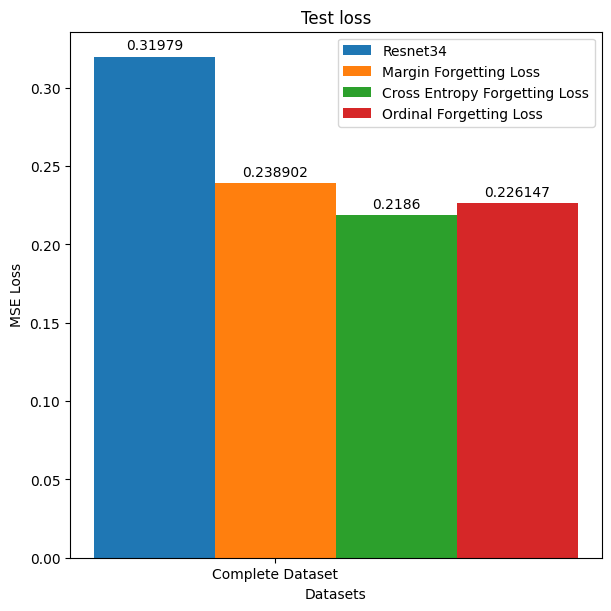

In [23]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [test_loss_cnn],
    "Margin Forgetting Loss": [test_loss_mar], 
    "Cross Entropy Forgetting Loss": [test_loss_ce],
    "Ordinal Forgetting Loss": [test_loss_ord]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Test loss", 'test_losses')

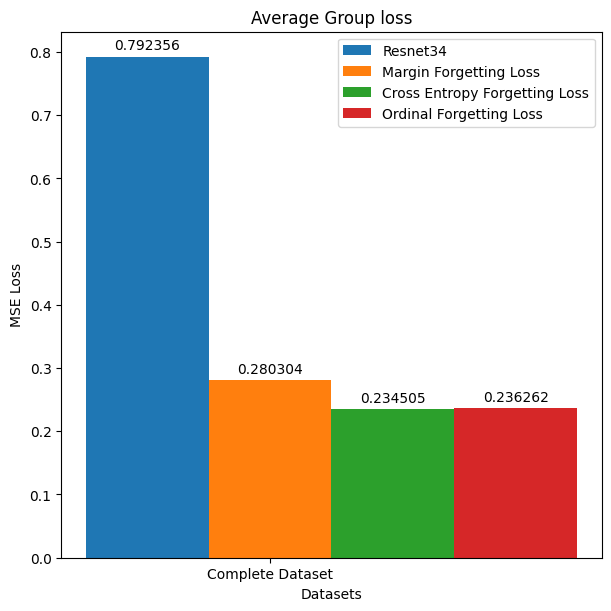

In [24]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [group_tst_loss_cnn],
    "Margin Forgetting Loss": [group_tst_loss_mar], 
    "Cross Entropy Forgetting Loss": [group_loss_ce],
    "Ordinal Forgetting Loss": [group_loss_ord]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Average Group loss", 'grp_test_losses')

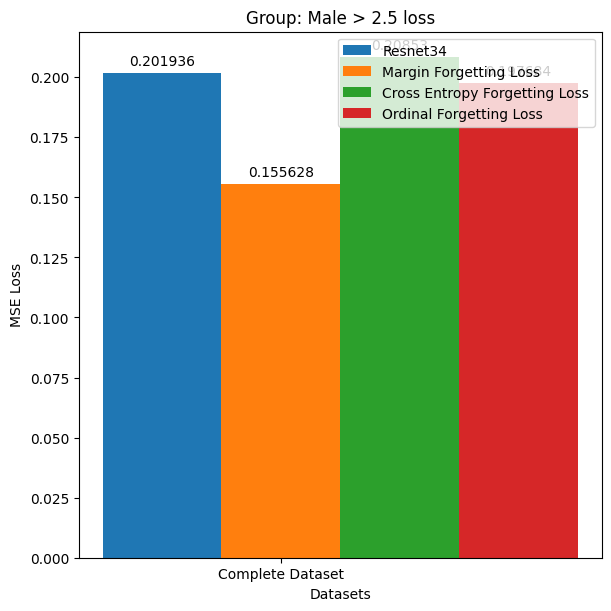

In [25]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['m b']],
    "Margin Forgetting Loss": [groups_fs_mar['m b']], 
    "Cross Entropy Forgetting Loss": [groups_ce['m b']],
    "Ordinal Forgetting Loss": [groups_ord['m b']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Male > 2.5 loss", 'test_losses')

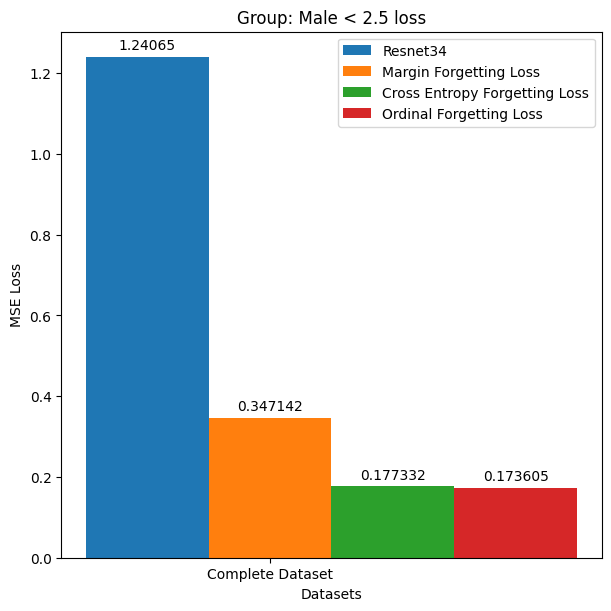

In [26]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['m u']],
    "Margin Forgetting Loss": [groups_fs_mar['m u']], 
    "Cross Entropy Forgetting Loss": [groups_ce['m u']],
    "Ordinal Forgetting Loss": [groups_ord['m u']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Male < 2.5 loss", 'test_losses')

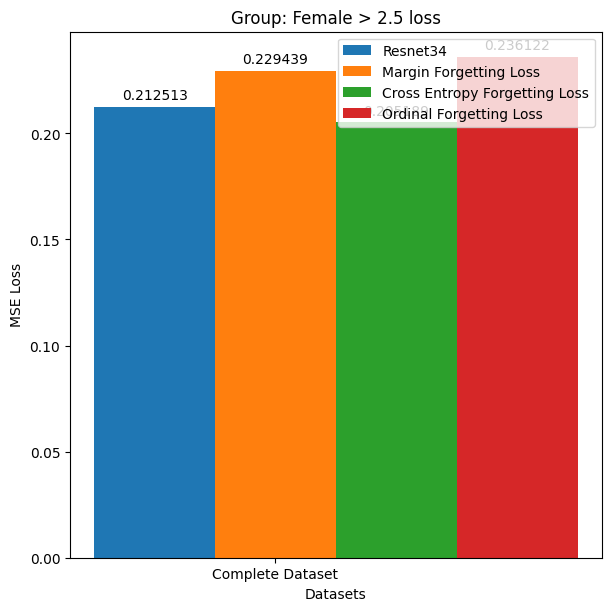

In [27]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['f b']],
    "Margin Forgetting Loss": [groups_fs_mar['f b']], 
    "Cross Entropy Forgetting Loss": [groups_ce['f b']],
    "Ordinal Forgetting Loss": [groups_ord['f b']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Female > 2.5 loss", 'test_losses')

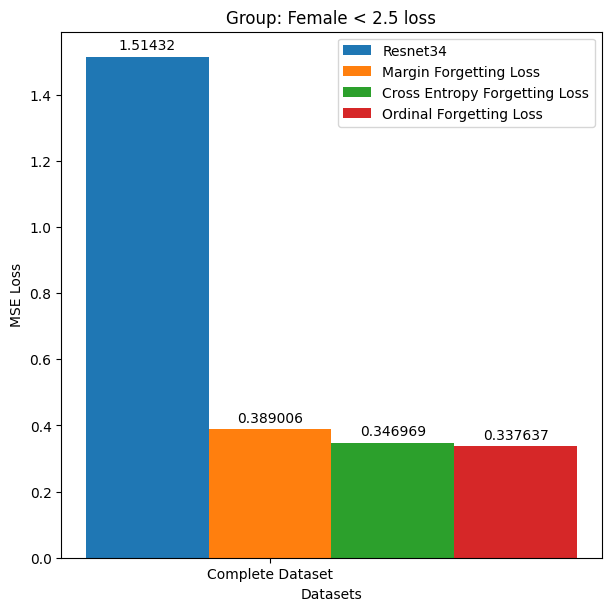

In [28]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['f u']],
    "Margin Forgetting Loss": [groups_fs_mar['f u']], 
    "Cross Entropy Forgetting Loss": [groups_ce['f u']],
    "Ordinal Forgetting Loss": [groups_ord['f u']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Female < 2.5 loss", 'test_losses')